# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks :
    + Data augmentation: flipped images, greylevel image editing, etc. You can explore the Keras image augmentation layers https://keras.io/api/layers/preprocessing_layers/image_augmentation/
    + SGD: Changing learning rate and momentum over time.
    + Training: Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.
+ To transform your solution in a Fully Convolutional Network (FCN) to make it independent of the input image size!


> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.
+ How you have implemented the FCN (including one inference example).

The final model can be developed in Tensorflow or in Keras.

In [1]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

# These files are also available in campus virtual

--2022-11-26 15:30:29--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2022-11-26 15:30:29--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2168274fd4e3b050b40d138f51.dl.dropboxusercontent.com/cd/0/inline/BxdnGZMjRP0iNKAC5423Pct6BVA0Ut9a6xarH5aO-0Vd57VxjR6NxQHe-4Z7y3LdJapyY_H7LZVd-QAHNlILonmqd4oNSrL0Ly_Tz4-j2f0KedL3eBYHSY2Dsi5eruFYVqQPlF3lyRiW-EOQ9zkIwSD2KjJKvwu6IjA7z08m4L6JRw/file# [following]
--2022-11-26 15:30:29--  https://uc2168274fd4e3b050b40d138f51.dl.dropboxusercontent.com/cd/0/inline/BxdnGZMjRP0iNKAC5423Pct6BVA0Ut9a6xarH5aO-0Vd57VxjR6NxQHe-4Z7y3LdJapyY_H7LZVd-QAHNlILonmqd4o

In [2]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    # y contains coordinates s.t: nose_x, nose_y, mouth_x, mouth_y. So x will be 0,2,4,.. and y will be 1,3,5,...
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10) # [0::2] yields the x ; [1::2] yields the x. Rearrenge inside [0,96] values.

In [3]:
[1,2,3,5,4,2,3,6,3,4,9,0,1,2,3,5,4,2,3,6,3,4,9,0][0::2], [1,2,3,5,4,2,3,6,3,4,9,0,1,2,3,5,4,2,3,6,3,4,9,0][1::2]

([1, 3, 4, 3, 3, 9, 1, 3, 4, 3, 3, 9], [2, 5, 2, 6, 4, 0, 2, 5, 2, 6, 4, 0])

In [4]:
# fname =FTRAIN
# df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

# # The Image column has pixel values separated by space; convert
# # the values to numpy arrays:
# df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

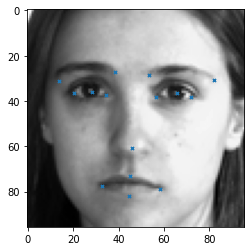

In [5]:
# loading data and checking it

X, y = load()
plot_sample(X[22],y[22])

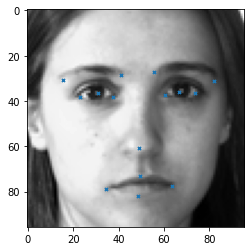

In [6]:
pyplot.imshow(X[22][:,::-1], cmap='gray')
pyplot.scatter(96 - (y[2][0::2] * 48 + 48), y[22][1::2] * 48 + 48, marker='x', s=10) # [0::2] yields the x ; [1::2] yields the x. Rearrenge inside [0,96] values.


In [7]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)

(1498, 96, 96, 1)



We need to invert labels to do the classifying correctly!

left_eye_center_x            0 -> 2\
left_eye_center_y            1 -> 3\
right_eye_center_x           2\
right_eye_center_y           3\
left_eye_inner_corner_x      4 -> 8\
left_eye_inner_corner_y      5 -> 9\
left_eye_outer_corner_x      6 -> 10\
left_eye_outer_corner_y      7 -> 11\
right_eye_inner_corner_x     8\
right_eye_inner_corner_y     9\
right_eye_outer_corner_x     10\
right_eye_outer_corner_y     11\
left_eyebrow_inner_end_x     12 -> 16\
left_eyebrow_inner_end_y     13 -> 17\
left_eyebrow_outer_end_x     14 -> 18\
left_eyebrow_outer_end_y     15 -> 19\
right_eyebrow_inner_end_x    16 \
right_eyebrow_inner_end_y    17\
right_eyebrow_outer_end_x    18\
right_eyebrow_outer_end_y    19\
nose_tip_x                   20 - 20\
nose_tip_y                   21 - 20\
mouth_left_corner_x          22 -> 24\
mouth_left_corner_y          23 -> 25\
mouth_right_corner_x         24 \
mouth_right_corner_y         25\
mouth_center_top_lip_x       26 -> 28\
mouth_center_top_lip_y       27 -> 29\
mouth_center_bottom_lip_x    28\
mouth_center_bottom_lip_y    29\


In [8]:
y

array([[ 0.3816111 , -0.21757638, -0.40208334, ...,  0.4403889 ,
         0.03376389,  0.8259514 ],
       [ 0.4330242 , -0.21624877, -0.3466828 , ...,  0.52398473,
        -0.08612007,  0.5925943 ],
       [ 0.3582826 , -0.26738405, -0.388     , ...,  0.41946375,
        -0.01155797,  0.67042756],
       ...,
       [ 0.40102914, -0.25295144, -0.3799806 , ...,  0.38052428,
        -0.01551456,  0.7536699 ],
       [ 0.45343795, -0.1929708 , -0.4018394 , ...,  0.7215474 ,
        -0.00937226,  0.8918613 ],
       [ 0.45054716, -0.32877925, -0.4011132 , ...,  0.4048302 ,
         0.06266037,  0.7168113 ]], dtype=float32)

In [9]:
# DATA AUGMENTATION
### Due to the complexity of the image nature, vertical flips do not make sense. Horizontal flips need to keep in mind the flip of labels.
def flip_horizontally(x, y):
  """
  Flip the image horizontally conserving the correct position of the labels.
  x: contains the image pixels.
  y: contains a list of list of n elements. coordinates x,y of the labels.
  Returns:
  x_flip: image flipped
  y_flip: labels adequatelly flipped.
  """
  y_x = -(y[:, 0::2]) # x coords. [-1,1], turn the indexes in order to scalate approp. 
  y_y = y[:, 1::2] # y coords 
  y_flip = []
  for i in range(y.shape[0]):
    # For each sample
    flip_sample = []
    for j in range(int(y.shape[1]/2)):
      # For each feature / 2 
        flip_sample.append(y_x[i][j])
        flip_sample.append(y_y[i][j])
    # Invert indices as stated before!
    flip_idxs = [(0, 2), (1, 3),(4, 8), (5, 9), (6, 10), (7, 11),(12, 16), (13, 17), (14, 18), (15, 19),(22, 24), (23, 25)]
    for j,k in flip_idxs:
      temp = flip_sample[j]
      flip_sample[j] = flip_sample[k]
      flip_sample[k] = temp
    # Concat to list
    y_flip.append(flip_sample)
  
  return x[:,:,::-1,:], np.asarray(y_flip)

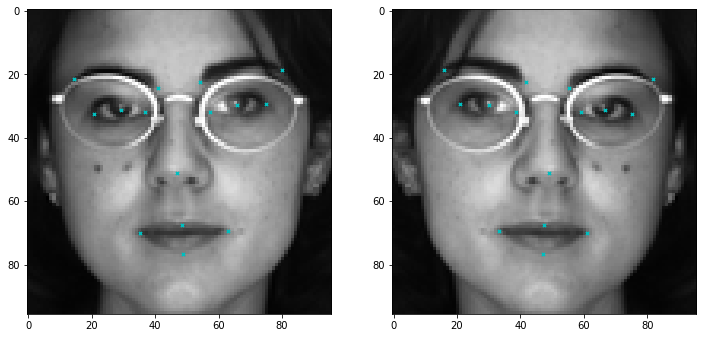

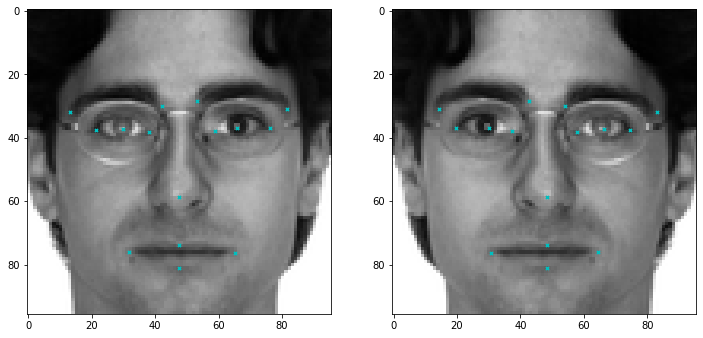

In [10]:
x_train_flip, y_train_flip = flip_horizontally(x_train, y_train)
image_number = 9
labels = y_train[image_number]*48 + 48
new_labels = y_train_flip[image_number]*48 + 48
fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(121)
#Original
ax.imshow(np.squeeze(x_train[image_number]), cmap='gray')
ax.scatter(labels[0::2], labels[1::2], marker='x', c='c', s=10)
ax2 = fig.add_subplot(122)
#Flipped
ax2.imshow(np.squeeze(x_train_flip[image_number]), cmap='gray')
ax2.scatter((new_labels[0::2]), new_labels[1::2], marker='x', c='c', s=10)

image_number = 90
labels = y_train[image_number]*48 + 48
new_labels = y_train_flip[image_number]*48 + 48
fig = pyplot.figure(figsize=(12,12))
ax = fig.add_subplot(121)
#Original
ax.imshow(np.squeeze(x_train[image_number]), cmap='gray')
ax.scatter(labels[0::2], labels[1::2], marker='x', c='c', s=10)
ax2 = fig.add_subplot(122)
#Flipped
ax2.imshow(np.squeeze(x_train_flip[image_number]), cmap='gray')
ax2.scatter((new_labels[0::2]), new_labels[1::2], marker='x', c='c', s=10)

In [11]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.RandomContrast(factor=(0.5,0.5), seed=42),
        layers.Conv2D(16, kernel_size=(3, 3), strides = (1, 1),activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), strides = (1, 1),activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
     
        layers.Conv2D(32, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
     
        # layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
     
        layers.Conv2D(128, kernel_size=(3, 3), strides = (1, 1),activation="relu", padding="same"),
        layers.Conv2D(128, kernel_size=(3, 3), strides = (1, 1),activation="relu", padding="same"),
        layers.Conv2D(128, kernel_size=(3, 3), strides = (1, 1),activation="relu", padding="same"),
     
        # layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
        # layers.Conv2D(256, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        # layers.Conv2D(256, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
     
        layers.Flatten(),
        # layers.Dense(1024, activation = 'relu'),
        layers.Dense(512, activation = 'relu'),
        # layers.Dense(256, activation = 'relu'),
        layers.Dropout(0.5),
        # layers.Dense(124, activation = 'relu'),
        layers.Dense(output_shape, activation="tanh"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast (RandomCont  (None, 96, 96, 1)        0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        9

In [12]:
X_augmented = np.concatenate((x_train, x_train_flip), axis=0)
y_augmented = np.concatenate((y_train, y_train_flip), axis=0)
X_train_aug, y_train_aug = flip_horizontally(X_augmented, y_augmented)
X_aug = np.concatenate((X_augmented, X_train_aug), axis=0)
y_aug = np.concatenate((y_augmented, y_train_aug), axis=0)
X_train_aug2, y_train_aug2 = flip_horizontally(X_aug, y_aug)
X_aug = np.concatenate((X_aug, X_train_aug2), axis=0)
y_aug = np.concatenate((y_aug, y_train_aug2), axis=0)

In [13]:
X_aug.shape, y_aug.shape

((11984, 96, 96, 1), (11984, 30))

In [ ]:
batch_size = 128
epochs = 300

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")
checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_acc',
                             verbose=1, 
                             save_weights_only=True, 
                             mode='max')
history = model.fit(X_aug, y_aug, batch_size=batch_size, epochs=epochs, validation_split = 0.15,
          callbacks = [checkpoint, EarlyStopping(monitor='val_loss', min_delta=0.00025, patience=10, verbose=1, mode='auto')])

Epoch 1/300


80/80 [==============================] - ETA: 0s - loss: 0.1251
Epoch 1: saving model to best_model.h5
80/80 [==============================] - 383s 5s/step - loss: 0.1251 - val_loss: 0.0673
Epoch 2/300
80/80 [==============================] - ETA: 0s - loss: 0.0800
Epoch 2: saving model to best_model.h5
80/80 [==============================] - 383s 5s/step - loss: 0.0800 - val_loss: 0.0683
Epoch 3/300
80/80 [==============================] - ETA: 0s - loss: 0.0760
Epoch 3: saving model to best_model.h5
80/80 [==============================] - 383s 5s/step - loss: 0.0760 - val_loss: 0.0674
Epoch 4/300
23/80 [=======>......................] - ETA: 4:24 - loss: 0.0745

In [ ]:
# batch_size = 32
# epochs = 200

# from keras import backend as K
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# def root_mean_squared_error(y_true, y_pred):
#         return K.sqrt(K.mean(K.square(y_pred - y_true)))

# model.compile(loss=root_mean_squared_error, optimizer="adam")
# checkpoint = ModelCheckpoint('best_model.h5', 
#                              monitor='val_acc',
#                              verbose=1, 
#                              save_weights_only=True, 
#                              mode='max')
# history = model.fit(X_aug, y_aug, batch_size=batch_size, epochs=epochs, validation_split = 0.2,
#           callbacks = [checkpoint, EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10, verbose=1, mode='auto')])

In [ ]:
history.history.keys()

In [ ]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Interesting to see that the model loss is lower than the train loss, which might be an effect caused by the dropout layer. 

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

In [ ]:
x_train.shape

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (None, None, 1)
output_shape = 30

model_FCN = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.RandomContrast(factor=(0.5,0.5), seed=42),
        layers.Conv2D(16, kernel_size=(3, 3), strides = (1, 1),activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), strides = (1, 1),activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
     
        layers.Conv2D(32, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
     
        layers.Conv2D(64, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
     
        # layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
     
        layers.Conv2D(128, kernel_size=(3, 3), strides = (1, 1),activation="relu", padding="same"),
        layers.Conv2D(128, kernel_size=(3, 3), strides = (1, 1),activation="relu", padding="same"),
        layers.Conv2D(128, kernel_size=(3, 3), strides = (1, 1),activation="relu", padding="same"),
     
        # layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
        # layers.Conv2D(256, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        # layers.Conv2D(256, kernel_size=(3, 3), strides = (1, 1), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
     
        # layers.Flatten(),
        # layers.Dense(1024, activation = 'relu'),
        layers.Dense(512, activation = 'relu'),
        # layers.Dense(256, activation = 'relu'),
        layers.Dropout(0.5),
     
        tf.keras.layers.Conv2D(output_shape, kernel_size=(6, 6), activation="linear"),
        tf.keras.layers.GlobalMaxPooling2D(),
        # layers.Dense(124, activation = 'relu'),
        # layers.Dense(output_shape, activation="tanh"),
    ]
)

model.summary()


In [ ]:
batch_size = 128
epochs = 300

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model_FCN.compile(loss=root_mean_squared_error, optimizer="adam")
checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_acc',
                             verbose=1, 
                             save_weights_only=True, 
                             mode='max')
history_FCN = model_FCN.fit(X_aug, y_aug, batch_size=batch_size, epochs=epochs, validation_split = 0.15,
          callbacks = [checkpoint, EarlyStopping(monitor='val_loss', min_delta=0.00025, patience=10, verbose=1, mode='auto')])

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.4 or less, it is an outstanding result!

**Answer**: The mean pixel error is

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**:

## What is the architecture of your FCN?
### Insert one of the test images in a larger image and show the detection result. The size of the face cannor change!



